# Kestrel Huntflow Compilation Across Multiple Execution Environments

#### Execution Environments in This Demo
- The first SQL-supported data store: `sqlite:///onpremise.db`
- The second SQL-supported data store: `sqlite:///cloud.db`
- A Python analytics `ask-AI` which could run in a sandbox environment such as AWS Lambda

#### How It Works

1. Kestrel compiles the entire huntflow into an Intermediate Representation Graph (IRGraph)
2. Kestrel segments the IRGraph based on execution boundaries of each environment
3. Kestrel sends the subgraphs to a Kestrel interface associated with each execution environment to execute
4. Each Kestrel interface compiles IRGraph into native execution language, e.g., SQL
5. Each Kestrel interface executes the subgraph in its specific environment and return results as DataFrames
6. Kestrel cache (a special store interface) per session maintains the intermediate results between interfaces

In [1]:
# first query into the `windows` table of `sqlite:///onpremise.db`

wid_named_pipe = GET file FROM sqlalchemy://GoldenSAML-WindowsEvents
                 WHERE name LIKE r'%##SSEE\sql\query%' # WID 2008
                    OR name LIKE r'%##WID\tsql\query%' # WID 2021+

In [2]:
# Python analytics does not run in the data store
# Kestrel detects the execution boundary of the Python analytics and put it in another executed subgraph
# this subgraph will be executed after the first one (SQL query) executed

APPLY python://ask-AI ON wid_named_pipe WITH prompt='What is the following pipe in Windows?', field='name'

In [3]:
# push the enriched data back to the data store (a temp table) and create a query for the following
# Kestrel will take care of entity identification, relation resolution, mapping, etc.

reader = FIND process CREATED wid_named_pipe

In [4]:
# another execution boundary detected since we switch to `sqlite:///cloud.db` (where the `msdefender` table is)
# Kestrel will handle the data movement between two data stores and use temp table
# note Kestrel will not execute the query due to its lazy evaluation feature

susp_mde_events = GET event FROM sqlalchemy://GoldenSAML-Microsoft365DefenderEvents
                  WHERE actor.process.pid = reader.pid
                    AND device.hostname = reader.endpoint.hostname

In [5]:
# this resides in the same data store as the last query
# Kestrel will put it in the same execution boundary of the last
# resulting a single nested query in `sqlite:///cloud.db`

queries = FIND query_info RESPONDED susp_mde_events

INTERFACE: sqlalchemy; STORE: goldensaml-onpremise


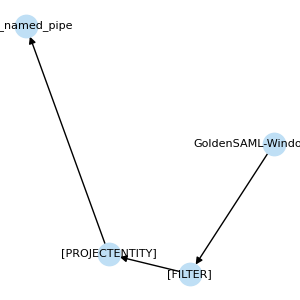

WITH wid_named_pipe AS 
 ( SELECT DISTINCT "Computer" AS "endpoint.hostname" , 
 "_ResourceId" AS "endpoint.uid" , 
 "PipeName" AS name , 
 "EventID" AS type_id 
 FROM windows 
 WHERE "PipeName" LIKE '%##SSEE\sql\query%' 
 OR "PipeName" LIKE '%##WID\tsql\query%' ) 
 SELECT DISTINCT * 
 FROM wid_named_pipe

INTERFACE: python; STORE: None


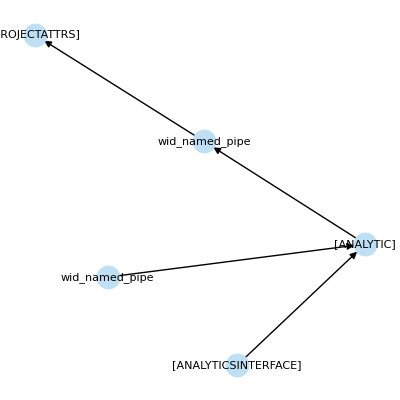

Analytics
~/workspace/kestrel/black-hat-us-2024/analytics/genai_emulator.py::analytics


INTERFACE: sqlalchemy; STORE: goldensaml-onpremise


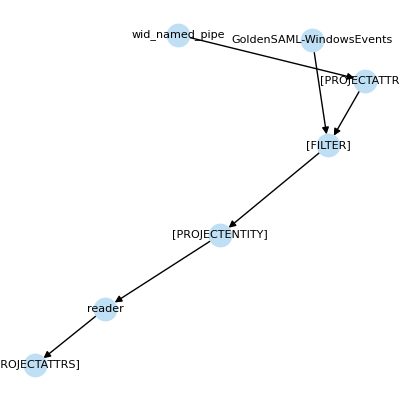

WITH reader AS 
 ( SELECT DISTINCT "Computer" AS "endpoint.hostname" , 
 "_ResourceId" AS "endpoint.uid" , 
 "Image" AS name , 
 "Image" AS "file.name" , 
 "Image" AS "file.path" , 
 "Image" AS "file.parent_folder" , 
 "ProcessId_dynamic" AS pid , 
 "ProcessGuid" AS UID 
 FROM windows 
 WHERE ( "PipeName" , 
 "_ResourceId" ) IN 
 ( SELECT DISTINCT * 
 FROM fdf2c149a602491abb2a2653d652a270 )) 
 SELECT DISTINCT pid 
 FROM reader

INTERFACE: sqlalchemy; STORE: goldensaml-onpremise


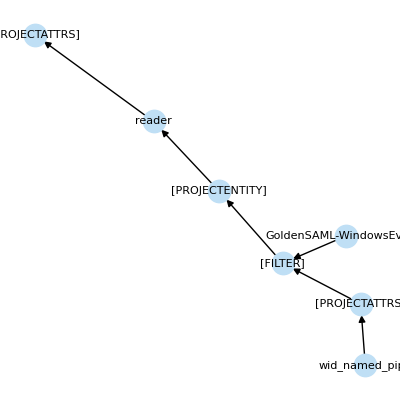

WITH reader AS 
 ( SELECT DISTINCT "Computer" AS "endpoint.hostname" , 
 "_ResourceId" AS "endpoint.uid" , 
 "Image" AS name , 
 "Image" AS "file.name" , 
 "Image" AS "file.path" , 
 "Image" AS "file.parent_folder" , 
 "ProcessId_dynamic" AS pid , 
 "ProcessGuid" AS UID 
 FROM windows 
 WHERE ( "PipeName" , 
 "_ResourceId" ) IN 
 ( SELECT DISTINCT * 
 FROM fdf2c149a602491abb2a2653d652a270 )) 
 SELECT DISTINCT "endpoint.hostname" 
 FROM reader

INTERFACE: sqlalchemy; STORE: goldensaml-cloud


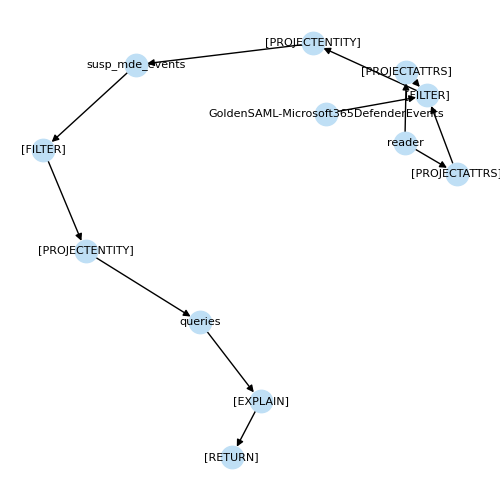

WITH susp_mde_events AS 
 ( SELECT DISTINCT "Timestamp" AS TIME , 
 "DeviceName" AS "device.hostname" , 
 "DeviceName" AS "file.endpoint.hostname" , 
 "DeviceName" AS "process.endpoint.hostname" , 
 "DeviceName" AS "actor.process.endpoint.hostname" , 
 "DeviceName" AS "actor.process.parent_process.endpoint.hostname" , 
 "DeviceName" AS "actor.user.endpoint.hostname" , 
 "DeviceId" AS "device.uid" , 
 "DeviceId" AS "file.endpoint.uid" , 
 "DeviceId" AS "process.endpoint.uid" , 
 "DeviceId" AS "actor.process.endpoint.uid" , 
 "DeviceId" AS "actor.process.parent_process.endpoint.uid" , 
 "DeviceId" AS "actor.user.endpoint.uid" , 
 "FileName" AS "file.name" , 
 "ProcessCommandLine" AS "process.cmd_line" , 
 "ProcessId" AS "process.pid" , 
 "ProcessId" AS "process.uid" , 
 "MD5" AS "process.hash.md5" , 
 "SHA1" AS "process.hash.sha1" , 
 "SHA256" AS "process.hash.sha256" , 
 "InitiatingProcessCommandLine" AS "actor.process.cmd_line" , 
 "InitiatingProcessId" AS "actor.process.pid" , 
 "InitiatingProcessId" AS "actor.process.uid" , 
 "InitiatingProcessParentId" AS "actor.process.parent_process.pid" , 
 "InitiatingProcessParentId" AS "actor.process.parent_process.uid" , 
 "InitiatingProcessParentFileName" AS "actor.process.parent_process.file.name" , 
 "InitiatingProcessFileName" AS "actor.process.file.name" , 
 "InitiatingProcessFolderPath" AS "actor.process.file.path" , 
 "InitiatingProcessFolderPath" AS "actor.process.file.parent_folder" , 
 "InitiatingProcessMD5" AS "actor.process.file.hash.md5" , 
 "InitiatingProcessSHA1" AS "actor.process.file.hash.sha1" , 
 "InitiatingProcessSHA256" AS "actor.process.file.hash.sha256" , 
 "InitiatingProcessAccountSid" AS "actor.user.uid" , 
 "InitiatingProcessAccountName" AS "actor.user.name" , 
 "InitiatingProcessAccountDomain" AS "actor.user.domain" , 
 "IPAddress" AS "src_endpoint.ip" , 
 "Port" AS "src_endpoint.port" , 
 "DestinationDeviceName" AS "dst_endpoint.hostname" , 
 "DestinationIPAddress" AS "dst_endpoint.ip" , 
 "DestinationPort" AS "dst_endpoint.port" , 
 "AccountDomain" AS "user.domain" , 
 "AccountName" AS "user.name" , 
 "AccountSid" AS "user.uid" , 
 "UserAgent" AS "http_request.user_agent" , 
 "ReportId" AS "query_info.uid" , 
 "ReportId" AS "entity.uid" , 
 "AdditionalFields.AttributeList" AS "query_info.attr_list" , 
 "AdditionalFields.SearchFilter" AS "query_info.search_filter" , 
 "ActivityObjects" AS "entity.data" , 
 "Permissions" AS PRIVILEGES , 
 "ActionType" AS type_uid , 
 "ActionType" AS type_name , 
 "RawEventData.ResultStatus" AS status_id 
 FROM msdefender 
 WHERE "InitiatingProcessId" IN 
 ( SELECT DISTINCT * 
 FROM "23b30f9b603948c7b8c8e8f532bfd535" ) 
 AND "DeviceName" IN 
 ( SELECT DISTINCT * 
 FROM "55d7a872ce534c39b4fd7d09c20072c7" )), 
 queries AS 
 ( SELECT DISTINCT "query_info.uid" AS UID , 
 "query_info.attr_list" AS attr_list , 
 "query_info.search_filter" AS search_filter 
 FROM susp_mde_events 
 WHERE 1 = 1 ) 
 SELECT DISTINCT * 
 FROM queries

In [6]:
# instead of executing, giving the instructions for execution

EXPLAIN queries

In [7]:
# let's execute the entire graph

DISP queries

uid,attr_list,search_filter
113597,"[""objectClass""]",(objectClass=*)
113598,"[""thumbnailphoto""]",(&(objectclass=contact)(!name=CryptoPolicy)(ThumbnailPhoto=*))
113608,"[""""]",(name=CryptoPolicy)
113616,"[""thumbnailphoto""]",(l=9736f74f-fd37-4b02-80e8-8120a72ad6c2)
113771,"[""""]","(&(objectCategory=user)(memberOf=CN=Domain Admins,CN=Users,DC=simulandlabs,DC=com))"
